# Amazon Fine Food Reviews

https://www.kaggle.com/snap/amazon-fine-food-reviews

## Hyperparameters

In [1]:
hyperparameters = {
    'limit': -1,
    'min_words': 2,
    'max_words': 200,
    'num_features': 20000,
    'downsample_ratio': 0.2,
    'num_trees': 10,
    'smoothing': 0.1,
    'max_categories': 5
}

## Load Dataset

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, HashingTF, IDF
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes
from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

df = spark.read.csv('Reviews.csv',header=False, schema=StructType([
    StructField('Id', IntegerType(), True),
    StructField('ProductId', StringType(), True),
    StructField('UserId', StringType(), True),
    StructField('ProfileName', StringType(), True),
    StructField('HelpfulnessNumerator', IntegerType(), True),
    StructField('HelpfulnessDenominator', IntegerType(), True),
    StructField('Score', IntegerType(), True),
    StructField('Time', IntegerType(), True),
    StructField('Summary', StringType(), True),
    StructField('Text', StringType(), True)]))
df = df.select('Id', 'Text', 'Summary', 'Score')
if hyperparameters['limit'] > 0:
    df = df.limit(hyperparameters['limit'])
df = df.filter('Id' > 0 and length('Text') > 0).filter(col('Score') > 0)

df.show()

+---+--------------------+--------------------+-----+
| Id|                Text|             Summary|Score|
+---+--------------------+--------------------+-----+
|  1|I have bought sev...|Good Quality Dog ...|    5|
|  2|"Product arrived ...|   Not as Advertised|    1|
|  3|"This is a confec...|"""Delight"" says...|    4|
|  4|If you are lookin...|      Cough Medicine|    2|
|  5|Great taffy at a ...|         Great taffy|    5|
|  6|I got a wild hair...|          Nice Taffy|    4|
|  7|This saltwater ta...|Great!  Just as g...|    5|
|  8|This taffy is so ...|Wonderful, tasty ...|    5|
|  9|Right now I'm mos...|          Yay Barley|    5|
| 10|This is a very he...|    Healthy Dog Food|    5|
| 11|I don't know if i...|The Best Hot Sauc...|    5|
| 12|One of my boys ne...|"My cats LOVE thi...|    5|
| 13|My cats have been...|My Cats Are Not F...|    1|
| 14|good flavor! thes...|   fresh and greasy!|    4|
| 15|The Strawberry Tw...|Strawberry Twizzl...|    5|
| 16|My daughter loves...|Lo

## Preprocess

In [3]:
df = RegexTokenizer(inputCol='Text', outputCol='Tokenized', pattern='\\W').transform(df)
df = RegexTokenizer(inputCol='Summary', outputCol='SummaryTokenized', pattern='\\W').transform(df)
df = df.withColumn('NumWords', size('Tokenized'))
df = df.withColumn('NumWordsSummary', size('SummaryTokenized'))

## Investigating the Data

In [4]:
print 'min review length (in words)', df.select(min('NumWords')).collect()[0][0]
print 'max review length (in words)', df.select(max('NumWords')).collect()[0][0]
print 'average review length (in words)', df.select(mean('NumWords')).collect()[0][0]

min review length (in words) 1
max review length (in words) 2258
average review length (in words) 72.0277417728


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1181dc0d0>]],
      dtype=object)

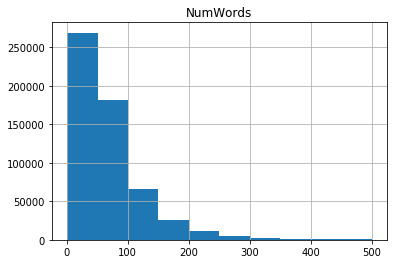

In [5]:
df.select('NumWords').toPandas().hist(range=[1, 500])

You can see that there are reviews with just one word and that there are reviews with a very high number of words but that for the most part most reviews are in the range of 50 words

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124b95150>]],
      dtype=object)

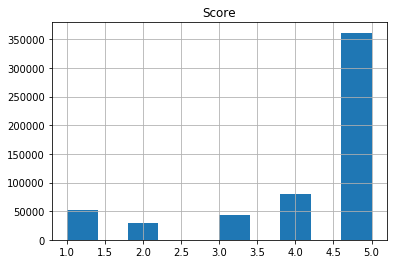

In [6]:
df.select('Score').toPandas().hist(range=[1, 5])

You can see that we have a very unbalanced dataset, most of the reviews are 5, we will have to down sample that later on

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114a83bd0>]],
      dtype=object)

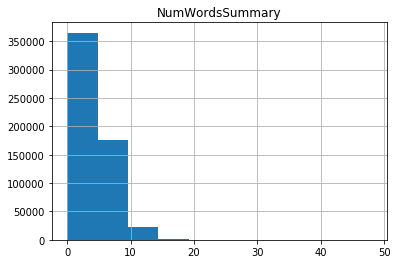

In [7]:
df.select('NumWordsSummary').toPandas().hist()

In [8]:
# text = [x[0] for x in df.select('Text').collect()]
# stopwords = set(STOPWORDS)
# stopwords.update(['amazon', 'br'])
# wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(text))
# plt.figure(figsize=[7,7])
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

Since this is a food review dataset it stands to reason that most of the words are food related

## Cleaning the Data

### Downsampling

In [9]:
temp = df.filter(col('Score') == 5)
df = df.filter(col('Score') != 5)
temp = temp.sample(hyperparameters['downsample_ratio'])
df = df.union(temp)

### Filtering Outliers

In [10]:
df = df.filter(col('NumWords') > hyperparameters['min_words'])
df = df.filter(col('NumWords') <= hyperparameters['max_words'])

In [11]:
# from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer

# indexer = StringIndexer(inputCol='Text', outputCol='categoryIndex')
# indexed = indexer.fit(df).transform(df)
# rows = indexed.select('categoryIndex').collect()

In [12]:
# model = OneHotEncoderEstimator(inputCols=['Tokenized'], outputCols=['output']).fit(indexed)
# model.transform(indexed).head().output

In [13]:
# text = [(x[0], x[1]) for x in df.select('Id', 'Tokenized').collect()]
# vocab = set([val for sublist in [set(x[1]) for x in text] for val in sublist])

72274


NameError: name 'sadlkj' is not defined

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(np.array(list(vocab)).reshape(-1, 1))
# data = [(x[0], list(enc.transform(np.array(x[1]).reshape(-1, 1)).toarray())) for x in text]
# data = [(x[0], [list(y) for y in x[1]]) for x in data]
# data

In [ ]:
# temp_df = spark.createDataFrame(data, ['Id', 'OneHotEncoded'])
# temp_df.show()

In [ ]:
# import numpy as np
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
# enc.fit(np.array(df.select('Text').collect()).reshape(-1, 1))
# ar = enc.transform(df.select('Text').collect()).toarray()

# for bit in ar[0]:
#     print bit


In [ ]:
# df = CountVectorizer(inputCol='Tokenized', outputCol='TokenizedVector', 
#                      vocabSize=30, minDF=2.0).fit(df).transform(df)

# df.show()
# asd

## After Cleanup

In [14]:
min_words = df.select(min('NumWords')).collect()[0][0]
print 'min review length (in words)', min_words
max_words = df.select(max('NumWords')).collect()[0][0]
print 'max review length (in words)', max_words
print 'average review length (in words)', df.select(mean('NumWords')).collect()[0][0]

min review length (in words) 3
max review length (in words) 200
average review length (in words) 65.6324478236


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120c35350>]],
      dtype=object)

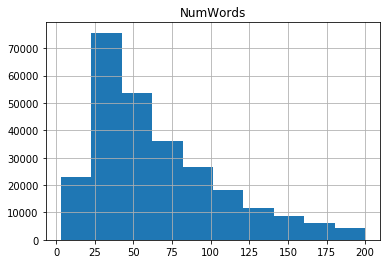

In [15]:
df.select('NumWords').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x147bc4750>]],
      dtype=object)

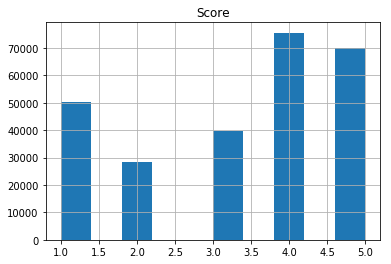

In [16]:
df.select('Score').toPandas().hist(range=[1, 5])

## Feature Engineering

In [17]:
df = df.withColumn('NumWordsNormalized', (col('NumWords') - min_words) / (max_words - min_words))
df = df.withColumn('ExclamationPoints', size(split(col('Text'), r'!')) - 1)
df = HashingTF(inputCol='Tokenized', outputCol='Tfidf', 
               numFeatures=hyperparameters['num_features']).transform(df)
df = HashingTF(inputCol='SummaryTokenized', outputCol='TfidfSummary', 
               numFeatures=hyperparameters['num_features']).transform(df)

df.show()

+---+--------------------+--------------------+-----+--------------------+--------------------+--------+---------------+-------------------+-----------------+--------------------+--------------------+
| Id|                Text|             Summary|Score|           Tokenized|    SummaryTokenized|NumWords|NumWordsSummary| NumWordsNormalized|ExclamationPoints|               Tfidf|        TfidfSummary|
+---+--------------------+--------------------+-----+--------------------+--------------------+--------+---------------+-------------------+-----------------+--------------------+--------------------+
|  2|"Product arrived ...|   Not as Advertised|    1|[product, arrived...|[not, as, adverti...|      32|              3|0.14720812182741116|                0|(20000,[572,1187,...|(20000,[572,9018,...|
|  3|"This is a confec...|"""Delight"" says...|    4|[this, is, a, con...|[delight, says, i...|      71|              4|0.34517766497461927|                0|(20000,[532,1860,...|(20000,[2495,6927

## Clustering

In [ ]:
dataset = df.select('NumWords', 'Score')
data = [(Vectors.dense([x[0], x[1]]),) for x in dataset.collect()]
dataset = spark.createDataFrame(data, ['features'])
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(dataset)
predictions = model.transform(dataset)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print 'Silhouette with squared euclidean distance = ' + str(silhouette)
centers = model.clusterCenters()
print 'Cluster Centers: '
for center in centers:
    print(center)

In [ ]:
# %matplotlib inline

# import matplotlib.pyplot as plt

# # plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = model.clusterCenters()
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Classification

In [23]:
dataset = df.select('TfidfSummary', 'Score').orderBy(rand()).withColumnRenamed(
    'TfidfSummary', 'features').withColumnRenamed('Score', 'label')
# data = [(x[1], x[0]) for x in dataset.collect()]
# dataset = spark.createDataFrame(data, ['label', 'features'])

### Logistic Regression

In [30]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
(training, testing) = dataset.randomSplit([0.7, 0.3], seed=42)
lrModel = lr.fit(training)
predictions = lrModel.transform(testing)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',
                                              metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print 'Test Error = %g ' % (1.0 - accuracy)
predictions.select('label', 'features').show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|       (20000,[],[])|    1|[-1.2888394529874...|[5.28545459350246...|       4.0|
|       (20000,[],[])|    1|[-1.2888394529874...|[5.28545459350246...|       4.0|
|       (20000,[],[])|    1|[-1.2888394529874...|[5.28545459350246...|       4.0|
|       (20000,[],[])|    3|[-1.2888394529874...|[5.28545459350246...|       4.0|
|       (20000,[],[])|    4|[-1.2888394529874...|[5.28545459350246...|       4.0|
|(20000,[0,572,408...|    3|[-1.2888394529874...|[5.28545459350246...|       4.0|
|(20000,[0,572,506...|    3|[-1.2888394529874...|[5.28545459350246...|       4.0|
|(20000,[0,572,573...|    3|[-1.2888394529874...|[5.28545459350246...|       4.0|
|(20000,[0,941,365...|    1|[-1.2888394529874...|[5.28545459350246...|       4.0|
|(20000,[0,941,4

### Evaluation

In [32]:
predictionAndLabels = sc.parallelize([(float(x[0]), float(x[1])) 
                                      for x in predictions.select('prediction', 'label').collect()])
metrics = MulticlassMetrics(predictionAndLabels)
print 'Summary Stats'
print 'Accuracy = %s' % metrics.accuracy
print 'Precision = %s' % metrics.precision()
print 'Recall = %s' % metrics.recall()
print 'F1 Score = %s' % metrics.fMeasure()
for label in [float(x) for x in range(1, 6)]:
    print 'Class %s precision = %s' % (label, metrics.precision(label))
    print 'Class %s recall = %s' % (label, metrics.recall(label))
    print 'Class %s F1 Measure = %s' % (label, metrics.fMeasure(label, beta=1.0))
print 'Weighted recall = %s' % metrics.weightedRecall
print 'Weighted precision = %s' % metrics.weightedPrecision
print 'Weighted F(1) Score = %s' % metrics.weightedFMeasure()
print 'Weighted F(0.5) Score = %s' % metrics.weightedFMeasure(beta=0.5)
print 'Weighted false positive rate = %s' % metrics.weightedFalsePositiveRate

Summary Stats
Accuracy = 0.28528418825
Precision = 0.28528418825
Recall = 0.28528418825
F1 Score = 0.28528418825
Class 1.0 precision = 0.0
Class 1.0 recall = 0.0
Class 1.0 F1 Measure = 0.0
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0
Class 3.0 precision = 0.0
Class 3.0 recall = 0.0
Class 3.0 F1 Measure = 0.0
Class 4.0 precision = 0.28528418825
Class 4.0 recall = 1.0
Class 4.0 F1 Measure = 0.44392390548
Class 5.0 precision = 0.0
Class 5.0 recall = 0.0
Class 5.0 F1 Measure = 0.0
Weighted recall = 0.28528418825
Weighted precision = 0.0813870680652
Weighted F(1) Score = 0.126644471019
Weighted F(0.5) Score = 0.0949611093336
Weighted false positive rate = 0.28528418825


### Random Forest

In [ ]:
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(dataset)
featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', 
                               maxCategories=hyperparameters['max_categories']).fit(dataset)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=42)
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', 
                            numTrees=hyperparameters['num_trees'])
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                               labels=labelIndexer.labels)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel', 
                                              predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print 'Test Error = %g ' % (1.0 - accuracy)
predictions.select('predictedLabel', 'label', 'features').show()

### Evaluation

In [ ]:
predictionAndLabels = sc.parallelize([(float(x[0]), float(x[1])) 
                                      for x in predictions.select('predictedLabel', 'label').collect()])
metrics = MulticlassMetrics(predictionAndLabels)
print 'Summary Stats'
print 'Accuracy = %s' % metrics.accuracy
print 'Precision = %s' % metrics.precision()
print 'Recall = %s' % metrics.recall()
print 'F1 Score = %s' % metrics.fMeasure()
for label in [float(x) for x in range(1, 6)]:
    print 'Class %s precision = %s' % (label, metrics.precision(label))
    print 'Class %s recall = %s' % (label, metrics.recall(label))
    print 'Class %s F1 Measure = %s' % (label, metrics.fMeasure(label, beta=1.0))
print 'Weighted recall = %s' % metrics.weightedRecall
print 'Weighted precision = %s' % metrics.weightedPrecision
print 'Weighted F(1) Score = %s' % metrics.weightedFMeasure()
print 'Weighted F(0.5) Score = %s' % metrics.weightedFMeasure(beta=0.5)
print 'Weighted false positive rate = %s' % metrics.weightedFalsePositiveRate

### NaiveBayes

In [24]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=42)
predictions = NaiveBayes(smoothing=hyperparameters['smoothing'], 
                         modelType='multinomial').fit(trainingData).transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',
                                              metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print 'Test Error = %g ' % (1.0 - accuracy)
predictions.select('label', 'features').show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|       (20000,[],[])|    1|[-1.6635304193209...|[0.18946889331216...|       3.0|
|       (20000,[],[])|    1|[-1.6635304193209...|[0.18946889331216...|       3.0|
|       (20000,[],[])|    3|[-1.6635304193209...|[0.18946889331216...|       3.0|
|(20000,[0,332,941...|    1|[-73.359434901034...|[0.21674963654276...|       2.0|
|(20000,[0,332,941...|    1|[-73.359434901034...|[0.21674963654276...|       2.0|
|(20000,[0,332,408...|    2|[-75.399185676728...|[5.47350996842138...|       3.0|
|(20000,[0,572,392...|    4|[-70.442964580578...|[0.00453700174388...|       2.0|
|(20000,[0,572,393...|    3|[-82.851597258361...|[0.00269268121911...|       2.0|
|(20000,[0,941,247...|    4|[-66.740541904092...|[4.99386781630339...|       2.0|
|(20000,[0,941,3

### Evaluation

In [20]:
predictionAndLabels = sc.parallelize([(float(x[0]), float(x[1])) 
                                      for x in predictions.select('prediction', 'label').collect()])
metrics = MulticlassMetrics(predictionAndLabels)
print 'Summary Stats'
print 'Accuracy = %s' % metrics.accuracy
print 'Precision = %s' % metrics.precision()
print 'Recall = %s' % metrics.recall()
print 'F1 Score = %s' % metrics.fMeasure()
for label in [float(x) for x in range(1, 6)]:
    print 'Class %s precision = %s' % (label, metrics.precision(label))
    print 'Class %s recall = %s' % (label, metrics.recall(label))
    print 'Class %s F1 Measure = %s' % (label, metrics.fMeasure(label, beta=1.0))
print 'Weighted recall = %s' % metrics.weightedRecall
print 'Weighted precision = %s' % metrics.weightedPrecision
print 'Weighted F(1) Score = %s' % metrics.weightedFMeasure()
print 'Weighted F(0.5) Score = %s' % metrics.weightedFMeasure(beta=0.5)
print 'Weighted false positive rate = %s' % metrics.weightedFalsePositiveRate

Summary Stats
Accuracy = 0.167470944922
Precision = 0.167470944922
Recall = 0.167470944922
F1 Score = 0.167470944922
Class 1.0 precision = 0.24070961718
Class 1.0 recall = 0.0862495817999
Class 1.0 F1 Measure = 0.126995073892
Class 2.0 precision = 0.159756219403
Class 2.0 recall = 0.188073394495
Class 2.0 F1 Measure = 0.172762141429
Class 3.0 precision = 0.149940760893
Class 3.0 recall = 0.282490079365
Class 3.0 F1 Measure = 0.19590081697
Class 4.0 precision = 0.288836262412
Class 4.0 recall = 0.308279012017
Class 4.0 F1 Measure = 0.298241098241
Class 5.0 precision = 0.0
Class 5.0 recall = 0.0
Class 5.0 F1 Measure = 0.0
Weighted recall = 0.167470944922
Weighted precision = 0.167797910606
Weighted F(1) Score = 0.157428201039
Weighted F(0.5) Score = 0.15977010918
Weighted false positive rate = 0.155016060466


### XG Boost

In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(dataset)
featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', maxCategories=4).fit(dataset)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=42)
gbt = GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', maxIter=10)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
predictions.select('prediction', 'indexedLabel', 'features').show(5)
evaluator = MulticlassClassificationEvaluator(
    labelCol='indexedLabel', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print 'Test Error = %g' % (1.0 - accuracy)
gbtModel = model.stages[2]
print gbtModel

Py4JJavaError: An error occurred while calling o652.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 88 tasks (1029.2 MB) is bigger than spark.driver.maxResultSize (1024.0 MB)
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1035)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1017)
	at org.apache.spark.ml.feature.VectorIndexer.fit(VectorIndexer.scala:154)
	at org.apache.spark.ml.feature.VectorIndexer.fit(VectorIndexer.scala:119)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
